In [1]:
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
#!pip install torch-geometric


In [2]:
#!pip install git+https://github.com/rusty1s/pyg_autoscale.git

In [1]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import torch_geometric
from torch_sparse import SparseTensor
from torch_geometric.data import Data
from torch_geometric_autoscale import metis, permute, SubgraphLoader
import numpy as np
from matplotlib import pyplot as plt
from torch_geometric.nn import SAGEConv
from torch_geometric_autoscale.models.base import ScalableGNN
from torch_geometric_autoscale import metis, permute, SubgraphLoader
from torch.nn import ModuleList
from datetime import datetime
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import to_undirected
import json
from uuid import UUID
from base64 import b64decode as b64d
import networkx as nx
from Model import Scalable
import pandas as pd
import torch
import pickle 
from torch_geometric.data.sampler import NeighborSampler

In [2]:
import random
import itertools
def dataprocess(data): #удаление ребер для валидации 
        #splitting data to train and test
        
        length=len(data.edge_index[0])
        shake_index  = (np.random.choice(list(range(length)), int(len(data.edge_index[0])),replace=False))
        data.edge_index = torch.transpose(torch.transpose(data.edge_index,0,1)[torch.tensor(shake_index,dtype=torch.long)],0,1)
       
        edges_list=data.edge_index.t().tolist()
        adj_list={}
        
        for edge in edges_list:
            if edge[0] not in adj_list:
                adj_list[edge[0]]=[edge[1]]
            else:
                adj_list[edge[0]].append(edge[1])
            if edge[1] not in adj_list:
                adj_list[edge[1]]=[edge[0]]
            else:
                adj_list[edge[1]].append(edge[0])
                

        non_edges=[]
        for i in range(int(length*0.2)):
            n=np.random.randint(len(data.x))
            m=np.random.randint(len(data.x))
            if n in adj_list:
                if m in adj_list[n]:
                    while m in adj_list[n]:
                        m = np.random.randint(len(data.x))
            non_edges.append([n,m])
            
        non_edges=torch.tensor(non_edges).t()
        val_edge_index=torch.cat((data.edge_index.t()[int(length*0.8):].t(),non_edges),1)
        y_true_val = [1]*int(len(data.edge_index.t()[int(length*0.8):]))+[0]*len(non_edges.t())
        
        data.edge_index =data.edge_index.t()[:int(length*0.8)].t()
        
        return data,non_edges,val_edge_index,y_true_val #data уже обрезанная по ребрам

In [3]:
with open('data_connected','rb') as f:
    data_init=pickle.load(f)

In [4]:
def di_to_undirected(data):
    data.edge_index=to_undirected(data.edge_index)
    data.adj_t=SparseTensor(row=data.edge_index[0],col=data.edge_index[1],sparse_sizes=(len(data.x),len(data.x)))
    #SparseTensor.from_edge_index(data.edge_index)
    return data

In [5]:
#data_init, mapping_new_to_old,mapping_old_to_new=data_load() #data_init - это самый изначальный граф, маппинги вершин
data_init,non_edges_val,val_edge_index,y_true_val = dataprocess(data_init) #data - здесь уже без части ребер, для валидации надо
data_init = di_to_undirected(data_init)#добавление ребер в обратную сторону

In [6]:
model = Scalable(num_of_nodes=len(data_init.x), in_channels=len(data_init.x[0]), hidden_channels=128,out_channels=128, num_layers=2)
model.load_state_dict(torch.load('model_parameters'))

#model.inference(new_vertices,old_vertices,rels)


<All keys matched successfully>

In [7]:
#perm, ptr = metis(dataset.adj_t, num_parts = 5000, log=True)
#data_init = permute(dataset, perm, log=True) 

In [8]:
device='cuda'
model.to(device)

Scalable(
  (histories): ModuleList(
    (0): History(789294, 128, emb_device=cpu, device=cuda:0)
  )
  (convs): ModuleList(
    (0): SAGEConv(768, 128)
    (1): SAGEConv(128, 128)
  )
  (pool): AsyncIOPool(pool_size=4, buffer_size=70000, embedding_dim=128, device=cuda:0)
)

In [9]:
def neg_samples(edge_index,ind,num_negative_samples): #возвращает негативные примеры
    d=datetime.now()
    neg_samples=torch.Tensor(size=(len(ind),num_negative_samples+1))
    neg_samples.t()[0] = ind
    for i in ind:
        d=datetime.now()
        neig=(edge_index[1][(edge_index[0]==i).nonzero(as_tuple=True)[0]])
        neg_neigbors=ind[~ind.unsqueeze(1).eq(neig).any(1)] #difference between all indices and neighbors
        neg_neigbors=(neg_neigbors[(neg_neigbors!=i).nonzero(as_tuple=True)[0]])
        #probs = torch.zeros(max(neg_neigbors)+1)
        d=datetime.now()
        #probs[neg_neigbors]=1
        d = datetime.now()
        neg_samples[i][1:]=torch.tensor(np.random.choice(neg_neigbors,num_negative_samples))
    return neg_samples

def edge_index(batch,size): #выбираются ребра только для батча и только для вершин внутри батча
    adj = batch.adj_t
    t = (adj.to_torch_sparse_coo_tensor()).coalesce()
    ind = torch.tensor(range(size))
    edge_index = t.indices().cpu()
    first = ((edge_index[0]<len(ind)).nonzero(as_tuple=True)[0])
    second = ((edge_index[1]<len(ind)).nonzero(as_tuple=True)[0])
    new_indices = (torch.tensor(np.intersect1d(first.cpu(),second.cpu())))
    edge_index1 =  edge_index[0][new_indices]
    edge_index2 = edge_index[1][new_indices]
    return (torch.stack([edge_index1, edge_index2], dim=0)),ind

In [10]:
def pos_samples(n_id,batch_size,adjs):
    for i,(edge_index, _, size) in enumerate(adjs):
        if i==1:
            ind = torch.tensor(range(size[1]))
            new_ind = (edge_index[0]<batch_size).nonzero(as_tuple=True)[0]
            #second = (edge_index[0]>=start_batch).nonzero(as_tuple=True)[0]
            #new_indices =  (torch.tensor(np.intersect1d(first.cpu(),second.cpu())))
            edge_index1 =  edge_index[0][new_ind]
            edge_index2 = edge_index[1][new_ind]
            return (torch.stack([edge_index1, edge_index2], dim=0)),ind

In [11]:
def mapping(e_index):
    s = sorted(list(set(e_index[0].tolist()).union(set(e_index[1].tolist()))))
    print('sss',s)
    mapping = {}
    k=0
    for i in (s):
        if i not in mapping:
            mapping[i] = k
            k+=1
    
    e_1 =torch.tensor(list(map(lambda x: mapping[x] , e_index[0].tolist())))
    e_2 = torch.tensor(list(map(lambda x: mapping[x] , e_index[1].tolist())))
    new_e_index=torch.stack([e_1, e_2], dim=0)
    
    return new_e_index

In [12]:
def train(model,data,loader,num_negative_smples,device):
    total_loss = 0
    model.train()
    l=len(loader)
    for i,args in enumerate(loader):
      #  print('{}/{}'.format(i,l))
        optimizer.zero_grad()
        (batch_size, n_id, adjs) = args
        #todo = подумать мб переделать 
        e_index,ind = pos_samples(n_id,batch_size,adjs)
       # e_index =mapping(e_index)
        pos = e_index.t()
        neg = neg_samples(e_index,ind,num_negative_smples)
        ###
        adjs = [adj.to(device) for adj in adjs]
        data_to_infer = data.x[n_id.to(device)].to(device)
            #data_to_infer = data_to_infer.to(device)
        out = model.forward(data_to_infer, adjs,batch_size,n_id)
        #print(out.shape)
        ###
        pos = pos.to(device)
        neg = neg.to(device)
        
        samples = (pos,neg)
        #print(out.shape)
        loss = model.loss(out, samples)
        loss.backward()
        ###
        optimizer.step() 
        total_loss+=loss
    return total_loss/len(loader)
   
def test(y_true,model,data,val_edge_index,loader):
    val_edge_index=(val_edge_index.t()).tolist() 
    model.eval()   
    preds = []
    outs=[]
    l=len(loader)
    for i,args in enumerate(loader):
            #print('{}/{}'.format(i,l))
            (batch_size, n_id, adjs) = args
            adjs = [adj.to(device) for adj in adjs]
            n_id = n_id.to(device)
            data_to_infer = data.x[n_id].to(device)
            #data_to_infer = data_to_infer.to(device)
            out = model.forward_for_val(data_to_infer, adjs)
            outs+=(out.cpu().tolist())

    outs=torch.tensor(outs)
    preds=[]
    all_ind=len(val_edge_index)
    for i,(e_from, e_to) in enumerate(val_edge_index):
        out_1=outs[e_from]
        out_2=outs[e_to]
        preds.append(float(torch.sigmoid(torch.dot(out_1,out_2))))
    return roc_auc_score(y_true,preds)

In [22]:
model = Scalable(num_of_nodes=len(data_init.x), in_channels=len(data_init.x[0]), hidden_channels=512,out_channels=256, num_layers=2)
model.to(device)

Scalable(
  (histories): ModuleList(
    (0): History(789294, 512, emb_device=cpu, device=cuda:0)
  )
  (convs): ModuleList(
    (0): SAGEConv(768, 512)
    (1): SAGEConv(512, 256)
  )
  (pool): AsyncIOPool(pool_size=4, buffer_size=70000, embedding_dim=512, device=cuda:0)
)

In [16]:
train_loader = NeighborSampler(data_init.edge_index, batch_size = 1000, sizes=[-1]*2)

In [29]:
d = datetime.now()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,weight_decay = 1e-5)
num_negative_smples=4
#losses_to_plot=[]
scores=[]
d=datetime.now()
for epoch in range(92,350):
        d=datetime.now()
        loss=train(model,data_init,train_loader,num_negative_smples,device)
        losses_to_plot.append(float(loss))
        print(epoch,loss)
        if epoch%11==0:
            torch.save(model.state_dict(),'model_parameters')
        print(datetime.now()-d)
plt.plot(losses_to_plot)
plt.show()
#plt.plot(torch.tensor(scores).tolist())
#plt.show()

92 tensor(0.7249, device='cuda:0', grad_fn=<DivBackward0>)
0:07:10.537233
93 tensor(0.7231, device='cuda:0', grad_fn=<DivBackward0>)
0:07:10.421050
94 tensor(0.7232, device='cuda:0', grad_fn=<DivBackward0>)
0:07:12.945003
95 tensor(0.7230, device='cuda:0', grad_fn=<DivBackward0>)
0:07:17.762876
96 tensor(0.7225, device='cuda:0', grad_fn=<DivBackward0>)
0:07:15.455833
97 tensor(0.7224, device='cuda:0', grad_fn=<DivBackward0>)
0:07:12.769316


KeyboardInterrupt: 

In [26]:
torch.save(model.state_dict(),'model_parameters')

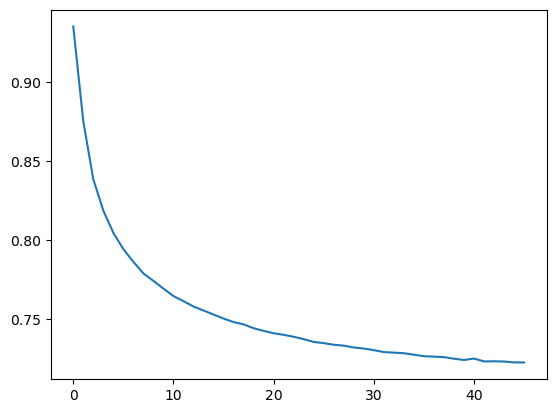

In [30]:
plt.plot(losses_to_plot) #256
plt.show()

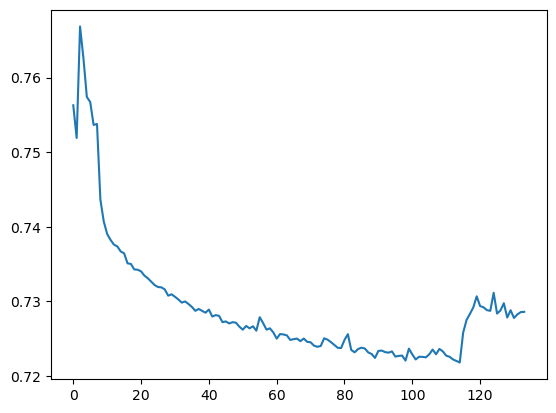

In [34]:
plt.plot(losses_to_plot) #128
plt.show()

In [ ]:
sum(sum(model.histories[0].emb))

In [ ]:
model.to(device)

In [28]:
#validation
d=datetime.now()
test_loader  = NeighborSampler(data_init.edge_index, batch_size = 1000, sizes=[-1]*2)
print(test(y_true_val,model,data_init,val_edge_index,test_loader))
print(datetime.now()-d)
#loss 0.7538 128 

0.8731328994535659
0:04:06.146188


In [ ]:
#validation
d=datetime.now()
test_loader  = NeighborSampler(data_init.edge_index, batch_size = 700, sizes=[-1]*2)
print(test(y_true_val,model,data_init,val_edge_index,test_loader))
print(datetime.now()-d)
#loss 0.7224 256

# Saving model

In [ ]:
torch.save(model.state_dict(),'model_parameters_proverka')

# Сам инференс

### принимает параметры: 
* vertex = tuple(id, text_emb)

* neighbors = [(id, text_emb), (..)] (list of tuples)

* neighbors_of_neighbors = [(id, text_emb), (..)]

In [ ]:
#test
x=model2.inference()

# plotting

In [ ]:
G = igraph.Graph.TupleList(rels, weights=False, directed=True)
igraph.summary(G)

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
# plot tree
init_notebook_mode()
def plot(G, annotations=False):

    lay = G.layout_fruchterman_reingold(grid="nogrid", niter=1000)
    nr_vertices = len(G.vs)
    position = {k: lay[k] for k in range(nr_vertices)}
    Y = [lay[k][1] for k in range(nr_vertices)]
    M = max(Y)
    labels = [x['name'] for x in G.vs()]
    es = igraph.EdgeSeq(G) # sequence of edges
    E = [e.tuple for e in G.es] # list of edges

    L = len(position)
    Xn = [position[k][0] for k in range(L)]
    Yn = [2*M-position[k][1] for k in range(L)]
    Xe = []
    Ye = []
    for edge in E:
        Xe+=[position[edge[0]][0],position[edge[1]][0], None]
        Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None] 


    #Create Plotly Traces

    lines = go.Scatter(x=Xe,
                       y=Ye,
                       mode='lines',
                       line=dict(color='rgb(210,210,210)', width=1),
                       hoverinfo='none'
                       )
    dots = go.Scatter(x=Xn,
                      y=Yn,
                      mode='markers',
                      name='',
                      marker=dict(  colorbar=dict(
                                        title="Modularity"
                                    ),
                                    colorscale="Viridis",
                                    
                                  
                                    line=dict(color='rgb(50,50,50)', width=1)
                                    ),
                      
                      hoverinfo='text',
                      opacity=0.8
                      )

    # Create Text Inside the Circle via Annotations

    def make_annotations(pos, text, font_size=10, 
                         font_color='rgb(0,0,0)'):
        L=len(pos)
        if len(text)!=L:
            raise ValueError('The lists pos and text must have the same len')
        annotations = go.Annotations()
        for k in range(L):
            annotations.append(
                go.Annotation(
                    text=labels[k], # or replace labels with a different list 
                                    # for the text within the circle  
                    x=pos[k][0], y=2*M-position[k][1],
                    xref='x1', yref='y1',
                    font=dict(color=font_color, size=font_size),
                    showarrow=False)
            )
        return annotations  

    # Add Axis Specifications and Create the Layout

    axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
                zeroline=False,
                showgrid=False,
                showticklabels=False,
                )
    ann = []
    if annotations:
        ann = make_annotations(position, labels)
    layout = dict(#title= 'Tree with Reingold-Tilford Layout',  
                  height=900,
                  annotations=ann,
                  font=dict(size=12),
                  showlegend=False,
                  xaxis=go.XAxis(axis),
                  yaxis=go.YAxis(axis),          
                  margin=dict(l=40, r=40, b=85, t=100),
                  hovermode='closest',
                  plot_bgcolor='rgb(248,248,248)'          
                  )

    # Plot

    data=go.Data([lines, dots])
    fig=dict(data=data, layout=layout)
    #fig['layout'].update(annotations=make_annotations(position, labels))
    iplot(fig, filename='Tree-Reingold-Tilf')
    # use py.plot instead of py.iplot if you're not using a Jupyter notebook

In [ ]:
plot(G)

# optuna todo 

In [ ]:
def objective(trial):
    
        data,mapping_new_to_old=data_loader()
        print(data)
        perm, ptr = metis(data.adj_t, num_parts=40, log=True)
        data_train = permute(data, perm, log=True)
        loader = SubgraphLoader(data_train, ptr, batch_size=10, shuffle=True)
        len(loader)

        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [64,128])
        size = trial.suggest_categorical("size of network, number of convs", [2,3])
        num_negative_samples=trial.suggest_categorical('num neg samples', [1,2,3,4,5,6,7,8,9,10])
        model = Scalable(num_nodes=len(data.x), in_channels=len(data.x[0]), hidden_channels=hidden_layer,out_channels=out_layer, num_layers=size)
        learning_rate= trial.suggest_float("lr",5e-4,1e-2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        for epoch in range(50):
            loss = train(model,loader,num_negative_smples)
        score=test(y_true_val,model,data,val_edge_index)
        
        trial.report(score,epoch)

        return score

In [ ]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials = 20)

print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key,value))

In [ ]:
def data_load(): #загрузить и обработать данные
   # with open('assets (16)','r', encoding="utf-8") as f:
    #    assets = json.load(f)

    with open('embeddings.json','r') as f:
        emb_map = json.load(f)

    #rels = []
    rels = pd.read_csv('relations.csv')
    rels=list(zip(list(rels['from']),list(rels['to'])))
    to_uuid = lambda x: str(UUID(b64d(x, altchars=None, validate=False).hex()))
    #for asset in assets:
     #   if asset['cited_articles']:
      #      source = to_uuid(asset['asset_id']['$binary'])
       #     for tt in  asset['cited_articles']:
        #        target = to_uuid(tt['$binary'])
         #       rels.append(tuple([source,target]))

    rels = [x for x in rels if x[0] in emb_map and x[1] in emb_map]
    mapping_old_to_new={}
    mapping_new_to_old = {}
    
    for id_new,id_old in enumerate(emb_map):
            mapping_old_to_new[id_old] = id_new
            mapping_new_to_old[id_new] = id_old
            
    x = []
    for id_new,id_old in enumerate(emb_map):
        x.append(emb_map[id_old]) 
        
    edges = list(map(lambda edge: [mapping_old_to_new[edge[0]], mapping_old_to_new[edge[1]]], rels)) 

    G = nx.Graph()
    G.add_edges_from(edges) #чтоб граф точно был направленным, в Graph ребра в одну сторону выписываются, хотя и считаются ненаправленными
    
    data_init = Data(x=torch.tensor(x),edge_index = torch.tensor(list(G.edges)).t() ) #тут все ребра
    return  data_init,mapping_new_to_old,mapping_old_to_new